<h3 align="center">
实验五: 非平衡电桥的应用
</h3>

请将第一个 python 单元格中的内容复制，**和你的实验报告的完整照片**提交给一个大语言模型（我们建议使用 Google Gemini 2.5 Pro 或者等价逻辑能力的LLM）。请在当前目录创建一个 `data.yaml` 文件，将其生成的 YAML 填入其中，其格式应当和 `data.example.yaml` 一致。运行所有单元格以生成数据分析报告。

In [17]:
"""
You are a lab agent, and your task is to extract data faithfully from the images provided. If no image is provided, please tell the user to upload photos of his or her lab report.

Read the following instructions carefully before you answer.
- The images should contain clear, handwritten text. If any part is unclear, ask the user to supply a clearer image or transcribe the unclear part.
- Pay special attention to the unit used by the user. Compare measure results with standard ones, and convert them if necessary. Automatically adjust magnitudes, and inform the user of the adjustments in text before the yaml snippet.
- When writing code you are expected to follow the given format strictly. If no warnings or failures occur, you should output a single yaml snippet, enclosed within triple backticks. You need not add extra comments to your answer. Do not output any text outside the code block except warnings or failure messages defined above.

Data related to NTC (aka temperature sensor):
- Resistance at 0°C, a value from 2000-10000 ohm. Extract to `ntc_r0: float`. Unit: ohm.
- Current for calibration, a value around 0.1mA. Extract to `ntc_ci: float`. Unit: mA.
- A table of temperature-voltage pairs. Extract to `ntc_temp: list[float]` and `ntc_volt: list[float]`. Unit: °C and mV.

Data related to Pt-100 (aka platinum resistance thermometer):
- Resistance at 0°C, a value around 100 ohm. Extract to `pt100_r0: float`. Unit: ohm.
- Current for calibration, a value around 1-10mA. Extract to `pt100_ci: float`. Unit: mA.
- A table of temperature-voltage pairs. Extract to `pt100_temp: list[float]` and `pt100_volt: list[float]`. Unit: °C and mV.

Sample output format:
```
# Date of the experiment
date: "YYYY-MM-DD"

ntc-data:
  # Rp at 0°C to balance the bridge (Ω)
  rp: null
  
  # Current through the bridge at 100°C calibration (mA)
  ci: null
  
  # Temperature readings (°C)
  temperature: []
  
  # Voltage readings (mV)
  voltage: []

pt100-data:
  # Rp at 0°C to balance the bridge (Ω)
  rp: null
  
  # Current through the bridge at 100°C calibration (mA)
  ci: null
  
  # Temperature readings (°C)
  temperature: []
  
  # Voltage readings (mV)
  voltage: []
```
"""

'\nYou are a lab agent, and your task is to extract data faithfully from the images provided. If no image is provided, please tell the user to upload photos of his or her lab report.\n\nRead the following instructions carefully before you answer.\n- The images should contain clear, handwritten text. If any part is unclear, ask the user to supply a clearer image or transcribe the unclear part.\n- Pay special attention to the unit used by the user. Compare measure results with standard ones, and convert them if necessary. Automatically adjust magnitudes, and inform the user of the adjustments in text before the yaml snippet.\n- When writing code you are expected to follow the given format strictly. If no warnings or failures occur, you should output a single yaml snippet, enclosed within triple backticks. You need not add extra comments to your answer. Do not output any text outside the code block except warnings or failure messages defined above.\n\nData related to NTC (aka temperature 

In [18]:
import yaml
import me

info_box_data = {
    "姓名": me.get_name(),
    "学号": me.get_id(),
}

try:
    with open("data.yaml", "r") as f:
        data = yaml.safe_load(f)
except FileNotFoundError:
    raise FileNotFoundError("data.yaml not found in current directory. Please make sure the file exists.")
except yaml.YAMLError as e:
    raise ValueError(f"Error parsing YAML file: {e}. Please ensure that the agent returned a valid YAML snippet.")

try:
    ntc_data = data["ntc-data"]
    ntc_rp = ntc_data["rp"]
    ntc_ci = ntc_data["ci"]
    ntc_temp = ntc_data["temperature"]
    ntc_volt = ntc_data["voltage"]

    pt100_data = data["pt100-data"]
    pt100_rp = pt100_data["rp"]
    pt100_ci = pt100_data["ci"]
    pt100_temp = pt100_data["temperature"]
    pt100_volt = pt100_data["voltage"]
    
    info_box_data["实验日期"] = data["date"]
except KeyError as e:
    raise KeyError(f"Missing expected key in YAML data: {e}. Please ensure all required fields are present.")

In [19]:
from rich.table import Table
from rich.console import Console
from math import log

def get_resistance_from_bridge(ci_ma: float, volt_mv: float, r_std: float, r_p: float) -> float:
    return (
        ci_ma * 1e-3 * r_std * r_p + (2 * r_std + r_p) * volt_mv * 1e-3
    ) / (ci_ma * 1e-3 * r_std - volt_mv * 1e-3)

ntc_r12 = 1000

ntc_kelvin = [t + 273.15 for t in ntc_temp]
ntc_resistance_a = [
    get_resistance_from_bridge(ntc_ci, v, ntc_r12, ntc_rp) for v in ntc_volt
]
ntc_resistance_b = [
    get_resistance_from_bridge(ntc_ci, -v, ntc_r12, ntc_rp) for v in ntc_volt
]
ntc_resistance = ntc_resistance_a if (
    ntc_resistance_a[0] > ntc_resistance_a[-1]
) else ntc_resistance_b

ntc_t_inv = [1 / t for t in ntc_kelvin]
ntc_ln_r = [log(r) for r in ntc_resistance]

table = Table(title="NTC Data")
table.add_column("Temperature (K)", justify="right", style="cyan", no_wrap=True)
table.add_column("Voltage (mV)", justify="right", style="yellow")
table.add_column("Resistance (Ohm)", justify="right", style="white")
table.add_column("1/T (1e-3/K)", justify="right", style="white")
table.add_column("ln(R)", justify="right", style="white")
for t, v, r, t_inv, ln_r in zip(ntc_kelvin, ntc_volt, ntc_resistance, ntc_t_inv, ntc_ln_r):
    table.add_row(f"{t:.2f}", f"{v:.2f}", f"{r:.1f}", f"{1000 * t_inv:.3f}", f"{ln_r:.3f}")
console = Console()
console.print(table)

                                  NTC Data                                  
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Temperature (K) ┃ Voltage (mV) ┃ Resistance (Ohm) ┃ 1/T (1e-3/K) ┃ ln(R) ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━┩
│          304.15 │        55.43 │           2443.2 │        3.288 │ 7.801 │
│          313.15 │        64.04 │           1921.8 │        3.193 │ 7.561 │
│          323.15 │        74.42 │           1351.0 │        3.095 │ 7.209 │
│          333.15 │        83.80 │            882.5 │        3.002 │ 6.783 │
│          343.15 │        90.05 │            592.3 │        2.914 │ 6.384 │
│          353.15 │        95.05 │            371.6 │        2.832 │ 5.918 │
│          363.15 │        98.40 │            229.1 │        2.754 │ 5.434 │
│          373.15 │       100.63 │            136.6 │        2.680 │ 4.917 │
└─────────────────┴──────────────┴──────────────────┴──────────────┴───────┘

{
    'k': np.float64(4828.3322391620595),
    'b': np.float64(-7.767164010142798),
    'r_squared': np.float64(0.9911587094823362)
}

NTC 线性回归结果：材料系数 B = 4.83e+03 K, R² = 0.991159

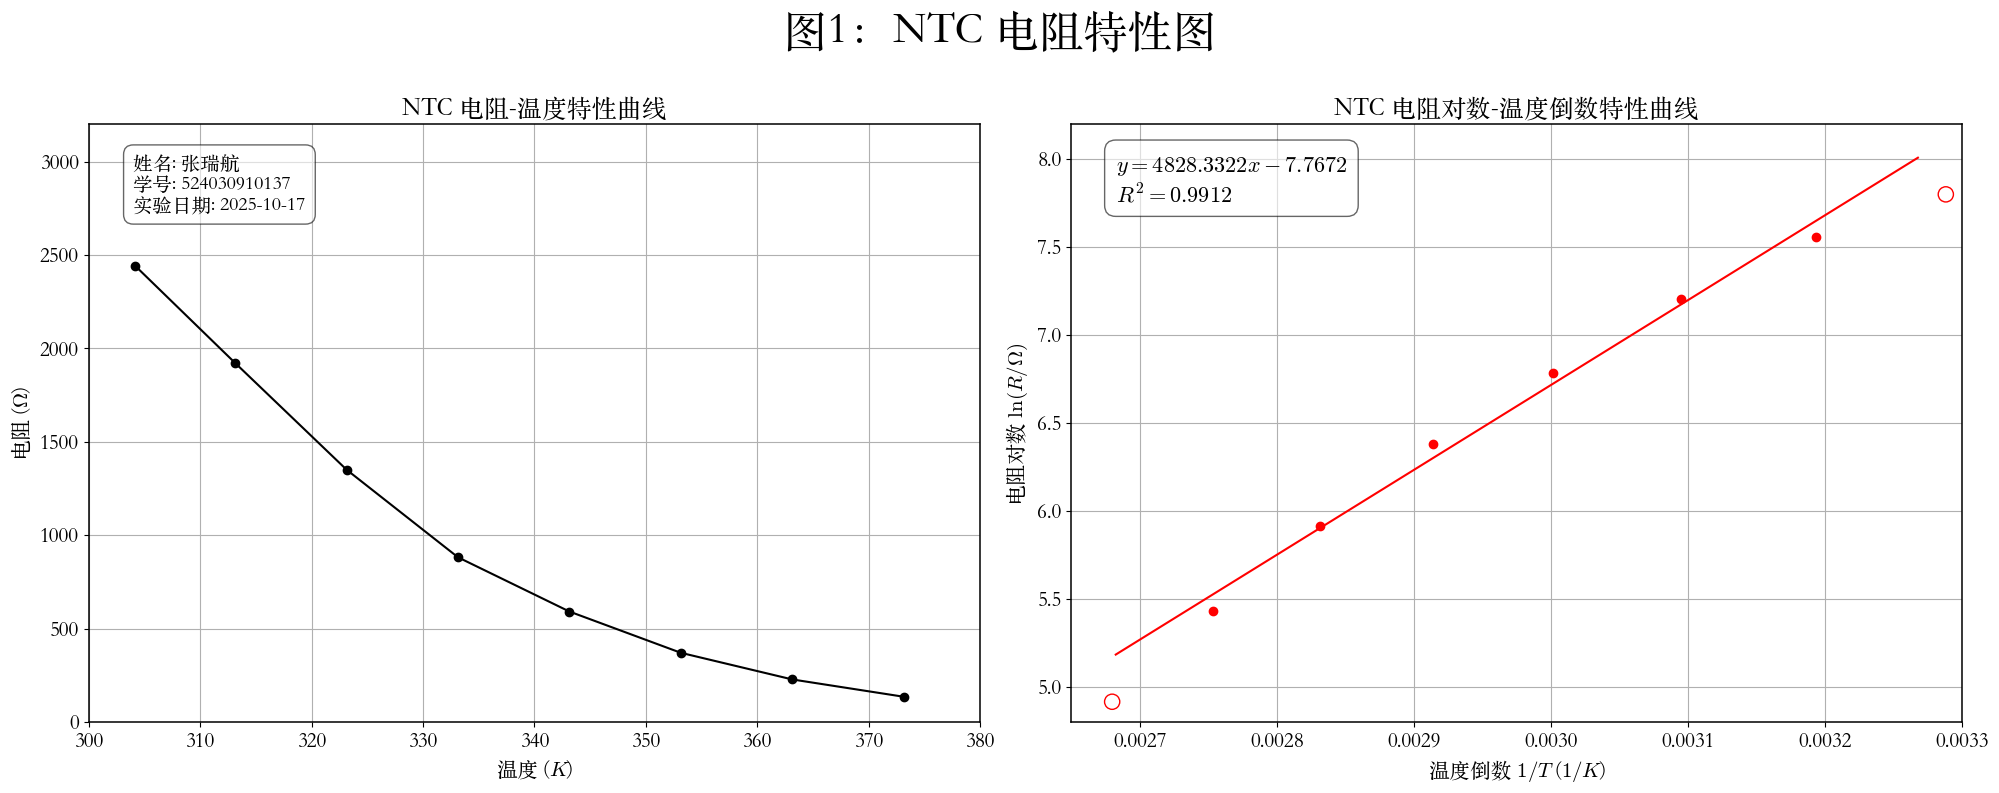

In [20]:
import graphing # noqa: F401 - import for side effects
from graphing import plot_graph
import matplotlib.pyplot as plt
from rich import print

plot1_options = {
    "title": "NTC 电阻-温度特性曲线",
    "xlabel": "温度 ($K$)",
    "ylabel": r"电阻 ($\Omega$)",
    "xlim": (300, 380),
    "ylim": (0, 3200),
    "color": "black",
    "exclude_points": [],
    "linear_regression": False,
    "info_box": {
        "location": "upper left",
        "data": info_box_data
    }
}

plot2_options = {
    "title": "NTC 电阻对数-温度倒数特性曲线",
    "xlabel": "温度倒数 $1/T$ ($1/K$)",
    "ylabel": r"电阻对数 $\mathrm{ln}(R/\Omega)$",
    "xlim": (0.00265, 0.00330),
    "ylim": (4.8, 8.2),
    "color": "red",
    "exclude_points": [0, 7],   # Exclude the first and last points from the fit
    "linear_regression": True,   # Enable regression for the second plot
    "regression_range": 0.9,
    "info_box": info_box_data
}

ntc_fig, (ntc_sub1, ntc_sub2) = plt.subplots(1, 2, figsize=(20, 8))
ntc_fig.suptitle('图1：NTC 电阻特性图', fontsize=32)

# Use the utility function to drive the plotting for each subplot
__ = plot_graph(ntc_sub1, ntc_kelvin, ntc_resistance, plot1_options)
lr = plot_graph(ntc_sub2, ntc_t_inv, ntc_ln_r, plot2_options)

# Show regression results
print(lr)
slope, intercept = lr["k"], lr["b"]
r_squared = lr["r_squared"]
print(f"[bold yellow]NTC 线性回归结果：[/bold yellow]材料系数 B = {slope:.2e} K, R² = {r_squared:.6f}")

# Adjust layout and show the plot
ntc_fig.tight_layout(pad=.5, rect=(0, 0, 1, 0.95)) # rect makes space for suptitle
plt.show()

In [21]:
pt100_r12 = 100
pt100_kelvin = [t + 273.15 for t in pt100_temp]
pt100_resistance_a = [
    get_resistance_from_bridge(pt100_ci, v, pt100_r12, pt100_rp) for v in pt100_volt
]
pt100_resistance_b = [
    get_resistance_from_bridge(pt100_ci, -v, pt100_r12, pt100_rp) for v in pt100_volt
]
pt100_resistance = pt100_resistance_a if (
    pt100_resistance_a[0] < pt100_resistance_a[-1]
) else pt100_resistance_b

table = Table(title="Pt-100 Data")
table.add_column("Temperature (K)", justify="right", style="cyan", no_wrap=True)
table.add_column("Voltage (mV)", justify="right", style="yellow")
table.add_column("Resistance (Ohm)", justify="right", style="white")
for t, v, r in zip(pt100_kelvin, pt100_volt, pt100_resistance):
    table.add_row(f"{t:.2f}", f"{v:.2f}", f"{r:.2f}")
console = Console()
console.print(table)

                     Pt-100 Data                     
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Temperature (K) ┃ Voltage (mV) ┃ Resistance (Ohm) ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│          308.03 │        17.20 │           112.23 │
│          313.15 │        20.23 │           114.44 │
│          323.15 │        25.46 │           118.31 │
│          333.15 │        30.87 │           122.40 │
│          343.15 │        35.75 │           126.15 │
│          353.15 │        41.12 │           130.36 │
│          363.15 │        45.68 │           134.00 │
│          373.15 │        50.14 │           137.62 │
└─────────────────┴──────────────┴──────────────────┘

Pt-100 线性回归结果：斜率 B0 = 3.89e-01 Ω/K, 截距 A0 = 98.96 Ω, R² = 0.999613

对比 Re = R0 (1 + A0) 得到：
R0 = 99.0 Ω
A = B0 / R0 = 3.930e-03 K^{-1}

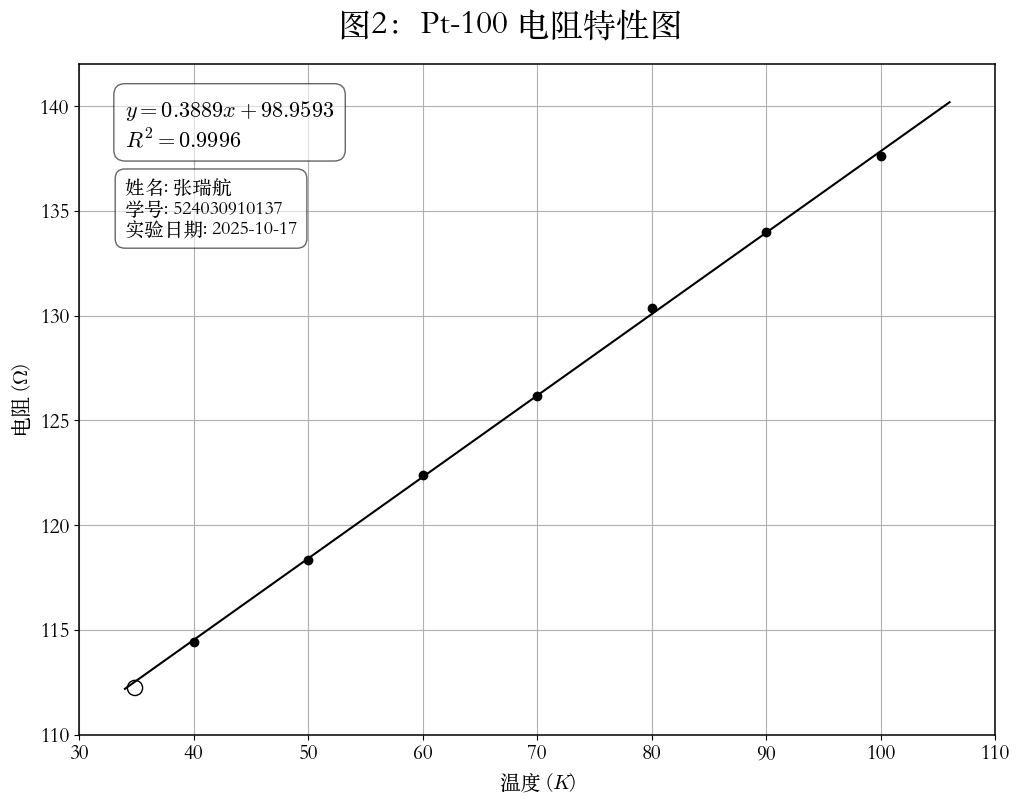

In [22]:
plot3_options = {
    "title": "",
    "xlabel": "温度 ($K$)",
    "ylabel": r"电阻 ($\Omega$)",
    "xlim": (30, 110),
    "ylim": (110, 142),
    "color": "black",
    "exclude_points": [0],
    "linear_regression": True,
    "info_box": {
        "location": "upper left",
        "offset": (0.0, -0.12),
        "data": info_box_data
    }
}

pt100_fig, pt100_sub = plt.subplots(1, 1, figsize=(10, 8))
pt100_fig.suptitle('图2：Pt-100 电阻特性图', fontsize=24)

lr = plot_graph(pt100_sub, pt100_temp, pt100_resistance, plot3_options)

# Show regression results
slope, intercept = lr["k"], lr["b"]
r_squared = lr["r_squared"]
print(f"[bold yellow]Pt-100 线性回归结果：[/bold yellow]斜率 B0 = {slope:.2e} Ω/K, 截距 A0 = {intercept:.2f} Ω, R² = {r_squared:.6f}")
x = ("对比 Re = R0 (1 + A0) 得到：") + '\n'
x += ("R0 = {:.1f} Ω".format(intercept)) + '\n'
x += ("A = B0 / R0 = {:.3e} K^{{-1}}".format(slope / intercept))
print(x)

pt100_fig.tight_layout(pad=0, rect=(0, 0, 1, 0.95)) # rect makes space for suptitle
plt.show()

In [23]:
# Save the two figures to disk

ntc_fig.savefig("output/ntc_characteristic_curve.png", dpi=300)
pt100_fig.savefig("output/pt100_characteristic_curve.png", dpi=300)